done in 1190.028s.
Checking for duplicate images...
   found 36 duplicated images


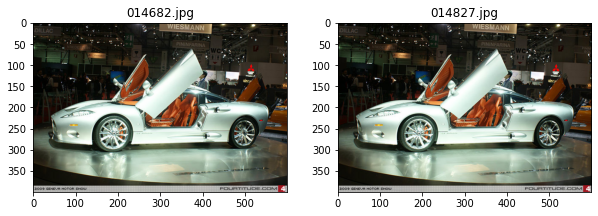

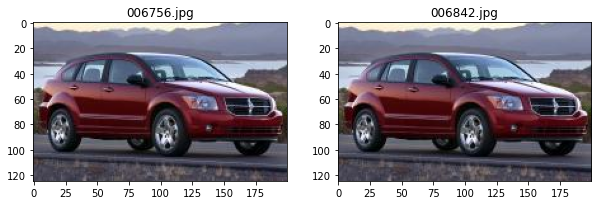

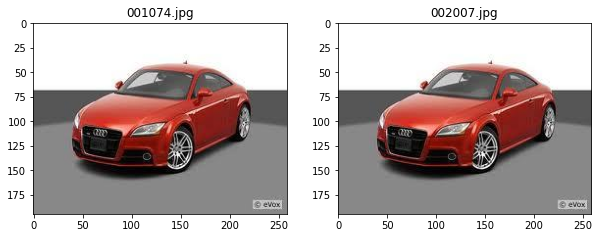

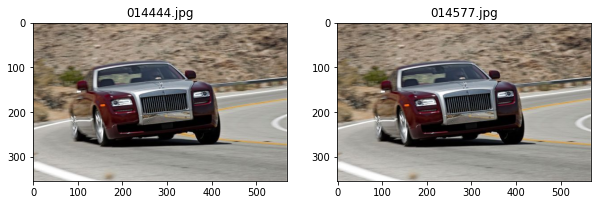

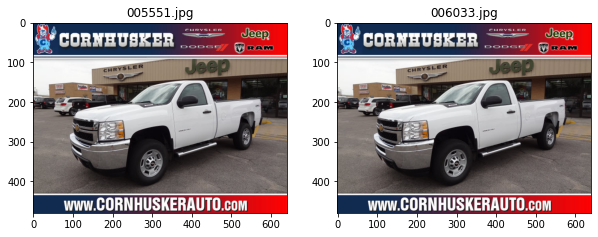

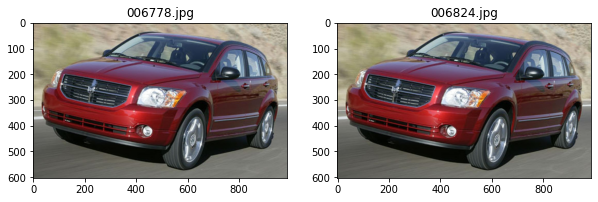

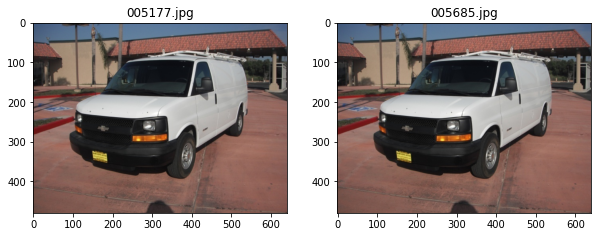

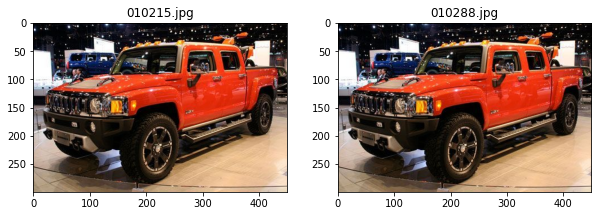

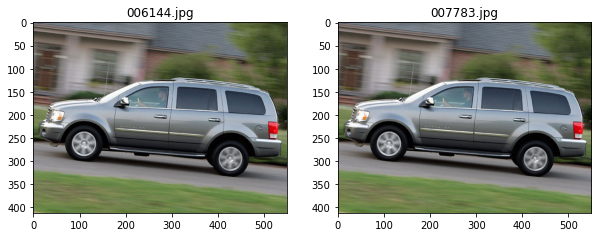

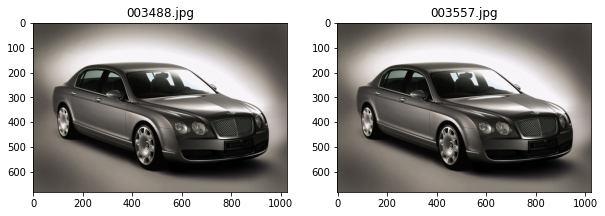

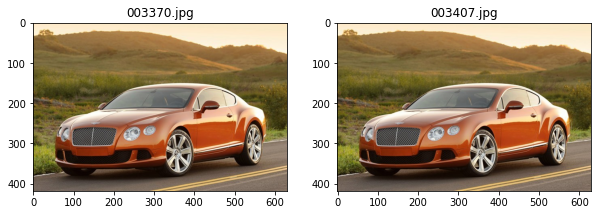

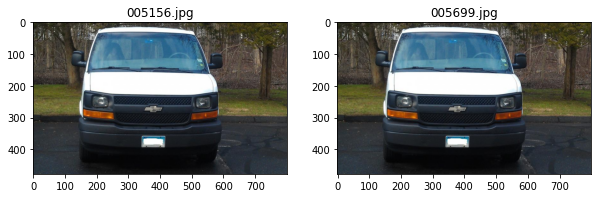

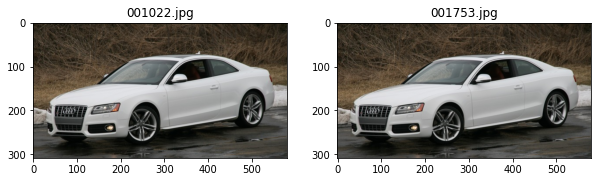

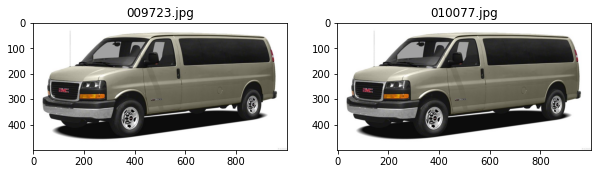

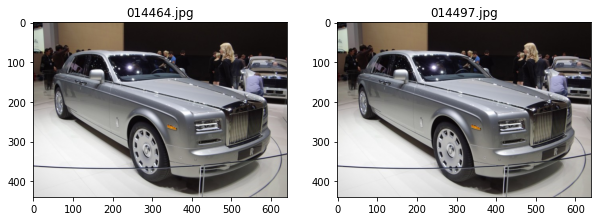

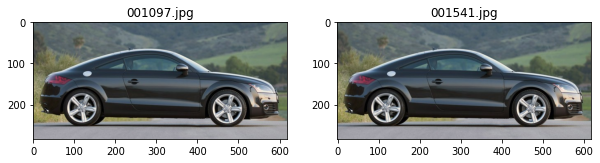

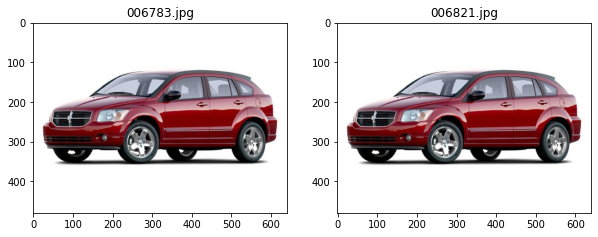

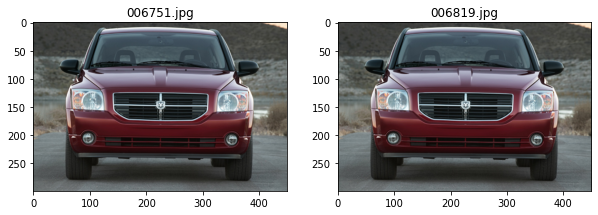

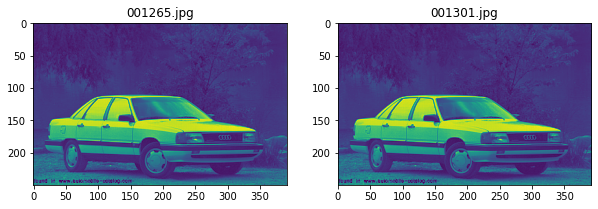

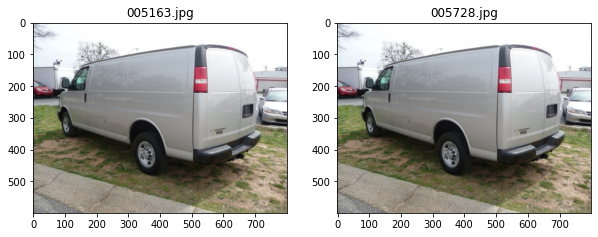

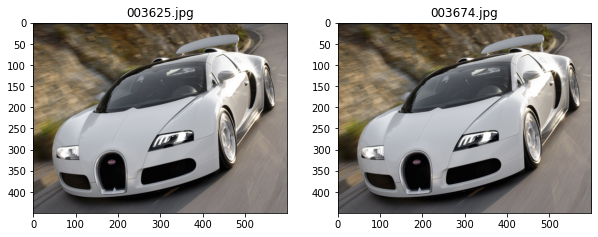

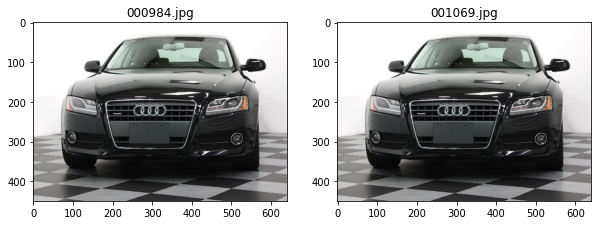

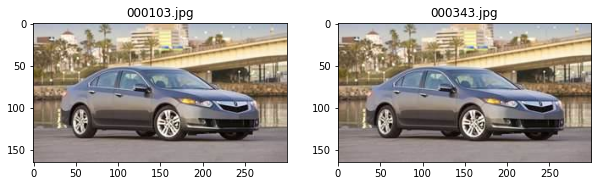

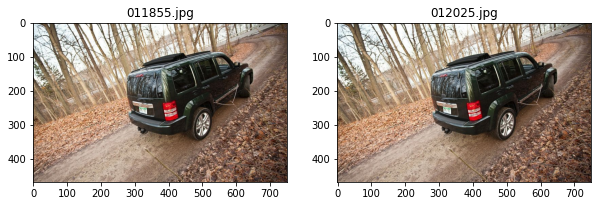

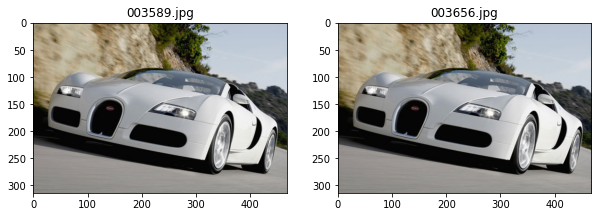

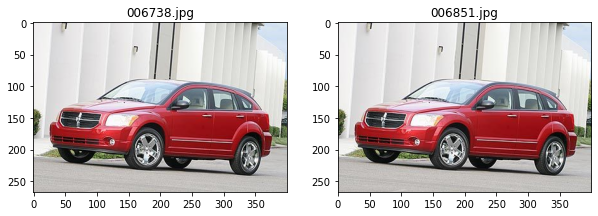

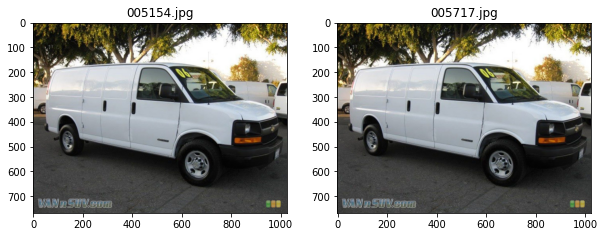

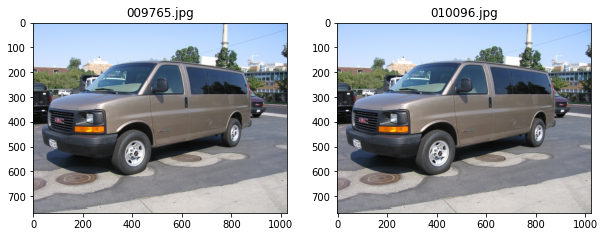

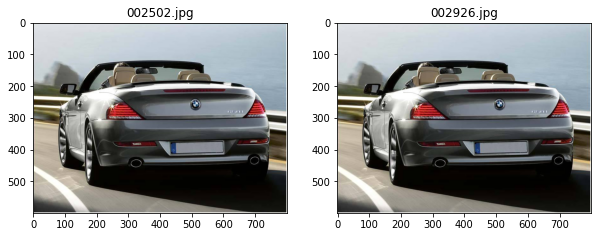

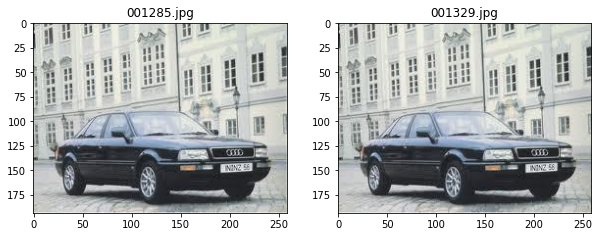

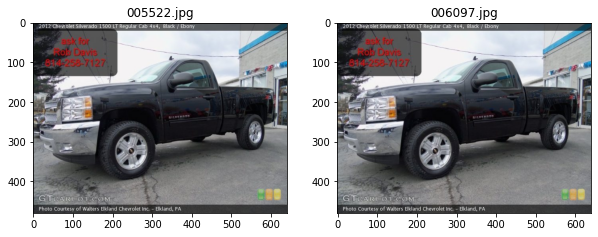

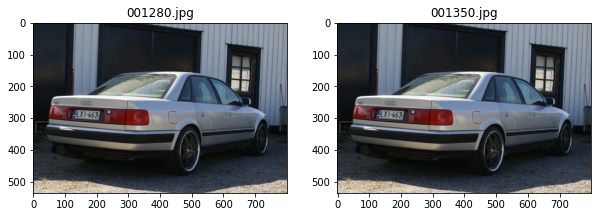

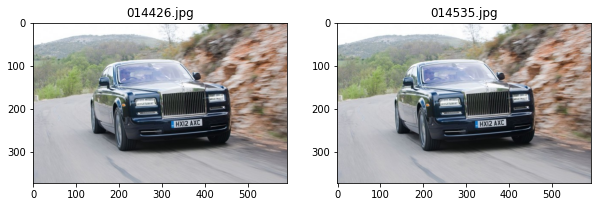

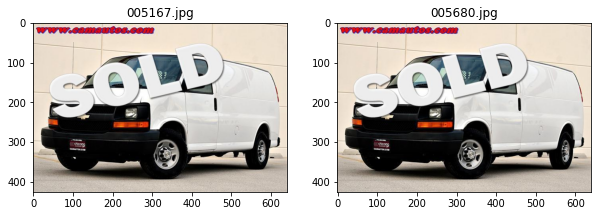

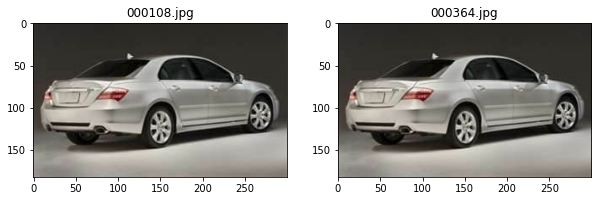

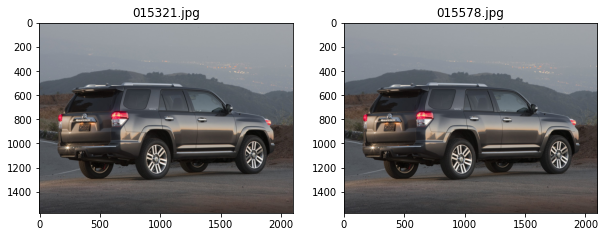

   moved the 36 duplicate files to del_dupl_imges folder
done in 55.869s.
Analyzing the existing test-train split...
--------------------------------------------------
Total no of examples                      : 16185
No of examples in train dataset           : 8144 , 50.3 % of total
No of examples in test dataset            : 8041 , 49.7 % of total
----------
For the train dataset:
   - Avg number of examples for a class   : 41.6
   - Min number of examples for a class   : 24 for class 136 . 57.7 % compared to the avg
   - Max number of examples for a class   : 68 for class 119 . 163.5 % compared to the avg
----------
For the test dataset:
   - Avg number of examples for a class   : 41.0
   - Min number of examples for a class   : 24 for class 136 . 58.5 % compared to the avg
   - Max number of examples for a class   : 68 for class 119 . 165.9 % compared to the avg
--------------------------------------------------


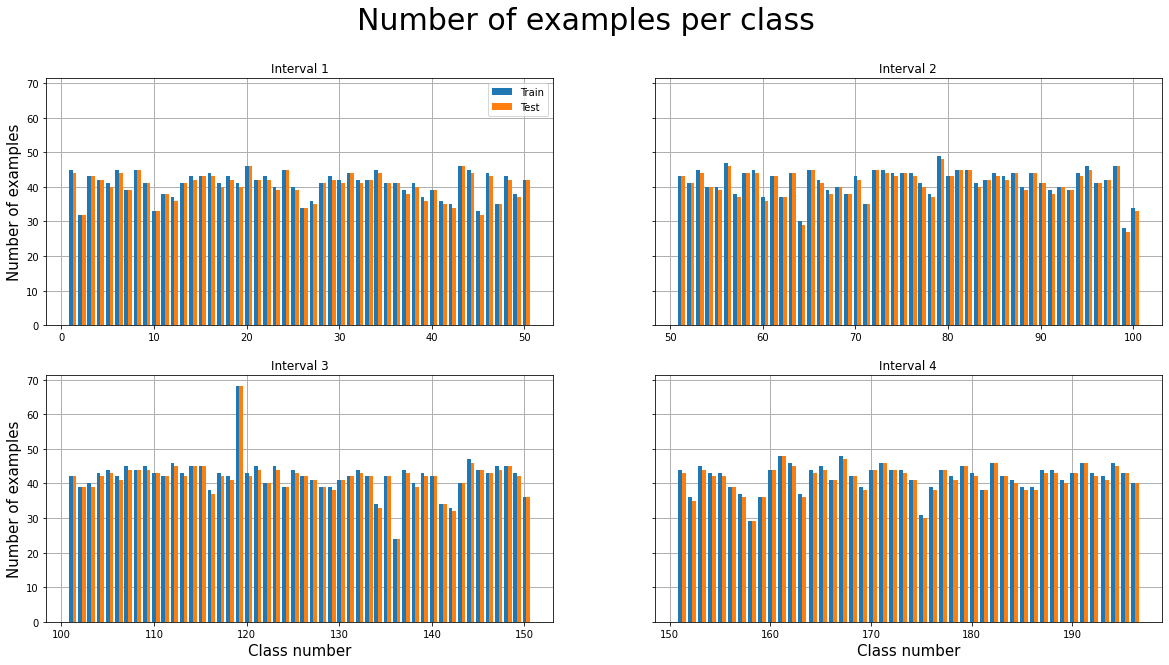

<Figure size 14.4x14.4 with 0 Axes>

done in 2.050s.
Saving all images with their bounding boxes in folder 'bb_images'...
done in 665.9s.
  Manual inspection revealed two copies of a rotated image. Correcting them... 
      Rotated image unzipped_files\car_ims\002568.jpg corrected
      Rotated image unzipped_files\cars_train\07389.jpg corrected
done in 0.123s.
Defining car type as a new class...
done in 0.393s.
Analyzing new class...
--------------------------------------------------
Total no of examples: 14872
----------
   - Avg number of examples    : 1652  per class
   - Min number of examples    : 498 for classes ['Wagon', 'Minivan'] . 30.1 % compared to the avg.
   - Max number of examples    : 3778 for class ['Sedan'] . 228.7 % compared to the avg.
--------------------------------------------------
done in 0.455s.
Modifying dataframes according to new classes...
done in 0.028s.
Splitting data with new classes to test / train...
  also preparing coordinates needed for yolo...

   preparing the following structure n

In [1]:
import os
import requests
import tarfile
import time

import scipy.io # for reading .mat files
import pandas as pd # for dataframes
import numpy as np #                               
import matplotlib.pyplot as plt # for graphs
import sys
import cv2 #for image manipulation
import random # for randomly separating test/test dataset
import shutil # for copying files in train/test folders
import yaml # for preparing yaml file

from PIL import Image



#PARAMETERS:

# analyse existing train_test splits (!!!!! downloads and exports 1.85Gb !!!!!):
ANALYSE_SPLIT = True

#preview of duplicate images found:
SHOW_DUPLICATES = True

# save images with bounding boxes (!!!!! Creates a folder for every images Gb !!!!)
# ment to be used for reviewing all bb
SAVE_BB = True

#view some random images with bb:
VIEW_RANDOM_BB = True

#set SEED for same "randomness"
SEED = 78

#GET_DATA from web:
GET_DATA = True



t0 = time.time()
t_init = time.time()
def download_file(url, file_path):
    # download the file from the given URL
    response = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(response.content)

def unzip_file(file_path, destination_folder):
    # extract the contents of the tar file to the destination folder
    success = False
    for attempt in range(2):
        with tarfile.open(file_path) as tar:
            try:
                tar.extractall(destination_folder)
                tar_contents = [member.name for member in tar.getmembers()]
                for file_in_tar in tar_contents:
                    if not os.path.exists(os.path.join(destination_folder, file_in_tar)):
                        raise Exception(f"Error in .tgz extraction: {file_in_tar} not found in {destination_folder}")
                success = True
                break
            except Exception as e:
                print(f"Attempt {attempt + 1} failed: {e}")

    if not success:
        print(f"Error: failed to extract {file_path} after 2 attempts")
    else:
        os.remove(file_path)

def get_data_from_sources():
    # URLs of the files to download
    print("Downloading and exporting the data...")
    file_urls = [
        'http://ai.stanford.edu/~jkrause/car196/car_ims.tgz', #all images
        'http://ai.stanford.edu/~jkrause/car196/cars_annos.mat', #Bounding boxes and labels for all images
        'https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz'
    ]

    test_train_urls = [
        'http://ai.stanford.edu/~jkrause/car196/cars_train.tgz', #train dataset
        'http://ai.stanford.edu/~jkrause/car196/cars_test.tgz', #test dataset
        'http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat', #test annotations
    ]
    
    if ANALYSE_SPLIT:
        file_urls = file_urls + test_train_urls

    # destination folder for the unzipped files
    destination_folder = './unzipped_files'
    os.makedirs(destination_folder, exist_ok=True)

    for url in file_urls:
        file_name = url.split('/')[-1]
        file_path = os.path.join(destination_folder, file_name)

        # download the file
        download_file(url, file_path)

        # unzip and delete the .tgz file
        if file_name.endswith('.tgz'):
            unzip_file(file_path, destination_folder)
            
    print("done in %0.3fs." % (time.time() - t0))

# if __name__ == '__main__':
#     if GET_DATA:
#         get_data_from_sources()
    
if GET_DATA:
    get_data_from_sources()



################################################################################
###
#Reading the data:
###


cars_meta = scipy.io.loadmat('unzipped_files/devkit/cars_meta.mat') # classes description
cars_annos = scipy.io.loadmat('unzipped_files/cars_annos.mat') # all examples in one folder
if ANALYSE_SPLIT:
    cars_test_annos = scipy.io.loadmat('unzipped_files/cars_test_annos_withlabels.mat') # annotations for test images
    cars_train = scipy.io.loadmat('unzipped_files/devkit/cars_train_annos.mat') # annotations for train images

print("Checking for duplicate images...")
t0 = time.time()


#Verify that all images in exported folder are included in the list


im_path = os.path.join('unzipped_files', 'car_ims')

def get_file_size(file_path):
    return os.stat(file_path).st_size

def get_duplicates(a_list):
    dupl_list = [an_element for an_element in a_list if a_list.count(an_element) > 1] 
    return set(dupl_list)

def get_dupl_element_idx_list(a_list, dupl_list):
    dupl_elems_idx_list = []
    for an_element in dupl_list:
        idx1 = a_list.index(an_element)
        a_list.reverse()
        idx2 = len(a_list) - a_list.index(an_element)-1
        a_list.reverse()
        idxes_of_element = [idx1,idx2]
        dupl_elems_idx_list.append(idxes_of_element)
    return(dupl_elems_idx_list)

fnames = []
bb_x1 = []
bb_y1 = []
bb_x2 = []
bb_y2 = []
class_idx_v0 = []
class_v0 = []

for i in range (len(cars_annos["annotations"][0])):
    fnames.append(cars_annos['annotations'][0][i][0][0].split('/')[1])
    bb_x1.append(cars_annos['annotations'][0][i][1][0][0])
    bb_y1.append(cars_annos['annotations'][0][i][2][0][0])
    bb_x2.append(cars_annos['annotations'][0][i][3][0][0])
    bb_y2.append(cars_annos['annotations'][0][i][4][0][0])
    class_idx = cars_annos['annotations'][0][i][5][0]
    class_v0.append(cars_annos['class_names'][0][class_idx-1][0])


sizes_list = []
try:
    for fname in fnames:
        fname_path = os.path.join(im_path,str(fname))
        sizes_list.append(get_file_size(fname_path))
except FileNotFoundError:
    print ('Not all files in car_ims folder. Check if duplication corrections happened')


#v0 for the raw data:
all_f_info_list_v0 = list(zip(fnames, bb_x1, bb_y1, bb_x2, bb_y2,class_v0,sizes_list))
all_f_info_df_v0 = pd.DataFrame(all_f_info_list_v0, columns=['fnames', 'bb_x1', 'bb_y1', 'bb_x2', 'bb_y2', 'class_v0','size'])

# # make a list of the file:
# fnames = [cars_annos['annotations'][0][i][0][0].split('/')[1] for i in range (len(cars_annos['annotations'][0]))]
# # make a list of their class
# classes_idx_v0 = [cars_annos['annotations'][0][i][-2][0] for i in range (len(cars_annos['annotations'][0]))]
# #class_v0 = [cars_annos['classes'][idx] for idx in classes_idx_v0]           

duplicates = get_duplicates(sizes_list)
dupl_idxes = get_dupl_element_idx_list(sizes_list,duplicates)

def compare_images(image1, image2):
    # Read the two images using OpenCV
    img1 = cv2.imread(image1)
    img2 = cv2.imread(image2)
    # Check if the images have the same shape
    if img1.shape != img2.shape:
        return False

    # Convert the images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Compare the value of random pixels in the images
    for i in range(100):
        x = np.random.randint(0, gray1.shape[0])
        y = np.random.randint(0, gray1.shape[1])
        if gray1[x][y] != gray2[x][y]:
            return False

    return True

def check_two_imges(im_path_1,im_path_2):
    """
    check if two images exist
    """
    return os.path.isfile(im_path_1) and os.path.isfile(im_path_2)

def get_dupl_pics():

    duplicate_img_no = 0
    duplicate_images = []
    for idxes in dupl_idxes:
        fname_a = fnames[idxes[0]]
        fname_b = fnames[idxes[1]]
        fname_a_path = os.path.join(im_path,fname_a)
        fname_b_path = os.path.join(im_path,fname_b)
        if compare_images(fname_a_path,fname_b_path):
            duplicate_img_no += 1
            duplicate_images.append([fname_a,fname_b])
            # else:
            #     raise Exception("Not all files present in car_ims folder")
    print (f'   found {duplicate_img_no} duplicated images')
    return (duplicate_images)
    

try: 
    same_images = get_dupl_pics()
except:
    print ("An error occurred. Check if duplicated files are already")
    

def plot_image_pairs(image_list, a_path):
    for images in image_list:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        img1 = plt.imread(os.path.join(a_path, images[0]))
        img2 = plt.imread(os.path.join(a_path, images[1]))
        ax1.imshow(img1)
        ax1.set_title(images[0])
        ax2.imshow(img2)
        ax2.set_title(images[1])
        plt.show()

if SHOW_DUPLICATES:
    plot_image_pairs(same_images,im_path)
    
def delete_file(file_path):
    try:
        os.remove(file_path)
        #print("File successfully deleted.")
    except FileNotFoundError:
        print(f"File {file_path} not found.")
    except PermissionError:
        print("You do not have permission to delete this file.")
        
def move_files(file_list, new_folder):
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)
    files_moved = 0
    for file in file_list:
        src = os.path.join(im_path, file)
        dst = os.path.join(new_folder, file)
        shutil.move(src, dst)
        files_moved +=1
    print (f'   moved the {files_moved} duplicate files to {new_folder} folder')


def get_del_file_names(ident_images = same_images):
    #del_file_names = [(im_path + dupl_names[1]) for dupl_names in ident_images]
    del_file_names = [(dupl_names[1]) for dupl_names in ident_images]
    return del_file_names
    
###
#For mutliple runs, better to move deleted images
###
files_to_delete = get_del_file_names()
folder1 = '\\unzipped_files'
try:
    move_files(files_to_delete, 'del_dupl_imges')
except FileNotFoundError:
    print ('Not all files in car_ims folder. Check if duplication checks happened')
###
#This deletes the images
###
# if len(same_images) > 0:
#     print("Deleting duplicates...")   
#     t0 = time.time()
    
#     files_to_delete = get_del_file_names()
#     deleted_files = 0
#     for file in files_to_delete:
#         delete_file(file)
#         deleted_files += 1
#     print (f'Deleted {deleted_files} images')
# print("done in %0.3fs." % (time.time() - t0))


#correcting annotations in the dataframe - v1:
#filter out from dataframe:
filtered_data = all_f_info_df_v0[~all_f_info_df_v0['fnames'].isin(files_to_delete)]
#v1 w/o the duplicates
all_f_info_df_v1 = filtered_data.copy(deep=True)
all_f_info_df_v1.reset_index(drop = True,inplace=True)
print("done in %0.3fs." % (time.time() - t0))


if ANALYSE_SPLIT:
    print("Analyzing the existing test-train split...")
    t0 = time.time()
    ###
    #Create a dataframe with example counts for each class, for each dataset (train/test/total)
    ###

    # Create a dataframe with number of class ('class_no') and the class description ('class_descr')
    classes = [str(cars_meta['class_names'][0][i][0]) for i in range(0,len(cars_meta['class_names'][0]))]
    classes_df = pd.DataFrame(classes, columns=['class_descr'])
    classes_df['class_no'] = classes_df.index + 1
    classes_df = classes_df[['class_no', 'class_descr']]


    #Helper fucntion: create a df with the class number and example counts for each class
    def examples_per_class (dataset):
        '''
        returns a df with the class for each image in the train/test/total dataset.
        Arguments:
            dataset -> (string) option for the analysis dataset, it can be either train or test
        Results:
            returns the dataframe
        '''
        if dataset == 'train':
            annotations = cars_train['annotations'][0] #showing the place where we find the class annotations for the training set
            col_name = 'train_exmpl_count'
            item_no = 4 #the position of the array to which the class is located
        elif dataset == 'test':
            annotations = cars_test_annos['annotations'][0]#showing the place where we find the class annotations for the test set
            col_name = 'test_exmpl_count'
            item_no = 4 #the position of the array to which the class is located
        elif dataset == 'total':
            annotations = cars_annos['annotations'][0]#showing the place where we find the class annotations for the test set
            col_name = 'total_exmpl_count'
            item_no = 5
        annos = [[element[0][0] for element in upperElement] for upperElement in annotations] #list of annotations per example
        class_list = [int(element[item_no]) for element in annos] # list of classes per example
        class_per_image = pd.DataFrame(class_list) # datafrane with the class for each example
        df2 = class_per_image.iloc[:, 0].value_counts().sort_index(ascending=True).to_frame() # dataframe with counts of examples per class
        df2.reset_index(inplace=True)
        df2 = df2.rename(columns = {'index':'class_no'})
        df2 = df2.rename(columns = {0:col_name})
        return df2


    # Create dataframes with the class and count for each dataset
    for dataset in ['test', 'train', 'total']:
        locals()[dataset+"_classes_df"] = examples_per_class(dataset)
        #Dataframes will be named: test_df, train_df and total_df accordingly
        

    # Merge the data frames together 
    classes_df = pd.merge(classes_df, train_classes_df, on = "class_no", how = "inner")
    classes_df = pd.merge(classes_df, test_classes_df, on = "class_no", how = "inner")
    classes_df = pd.merge(classes_df, total_classes_df, on = "class_no", how = "inner")

    ###
    # Analysis of counts per class 
    ###


    # Helper function: calulates min,max and average number of examples for a dataset
    def stats (dataset, df = classes_df):
        '''
        Calculate min, max and average number of examples per dataset, per class
        Arguments:
            dataset -> (sting) can be either 'test' or 'train'
            df -> a dataframe that has columns train_exmpl_count or test_exmpl_count. Default is classes_df 
        Result:
            Returns five numbers:  min_, min_class, max_, max_class, mean_:
                min_ -> minimum number of examples
                min_class -> class with the least number of examples
                max_ -> maximum number of examples
                max_class -> class with maximum number of examples
                mean_ -> mean numer of examples per class for the dataframe used
        '''
        if dataset == 'train':
            column = 'train_exmpl_count'
        elif dataset == 'test':
            column = 'test_exmpl_count'
        else:
            raise Exception("choose dataset value to be either 'test' or 'train'")
        
        class_column = 'class_no'
        min_ = df[column].min()
        min_class = int(df[class_column].loc[(df[column] == min_)])
        max_ = df[column].max()
        max_class = int(df[class_column].loc[(df[column] == max_)])
        mean_ = round(df[column].mean(),1)  
        return min_, min_class, max_, max_class, mean_


    #Comparing numbers per dataset
    train_exmpl_no = len(cars_train['annotations'][0])    # Correct naming (exmpl Vs examples, no Vs count)
    test_exmpl_no = len(cars_test_annos['annotations'][0])     # Correct naming
    total_exmpl_no = test_exmpl_no + train_exmpl_no
    test_prc = round(test_exmpl_no / total_exmpl_no * 100, 1)
    train_prc = round(train_exmpl_no / total_exmpl_no * 100, 1)

    #Calculate min, max and average number of examples per dataset per class
    train_min, train_min_class, train_max, train_max_class, train_av = stats(dataset = 'train')
    test_min, test_min_class, test_max, test_max_class, test_av = stats(dataset = 'test')


    print ('--------------------------------------------------')
    print ('Total no of examples                      :',total_exmpl_no)
    print ('No of examples in train dataset           :',train_exmpl_no,',',train_prc ,'% of total')
    print ('No of examples in test dataset            :',test_exmpl_no,',', test_prc,'% of total')



    #Show results
    print ('----------')
    print ('For the train dataset:')
    print ('   - Avg number of examples for a class   :',train_av)
    print ('   - Min number of examples for a class   :',train_min,
        'for class', train_min_class,'.', round(train_min*100/train_av,1), "% compared to the avg")
    print ('   - Max number of examples for a class   :',train_max,
        'for class',train_max_class,'.',round(train_max*100/train_av,1), "% compared to the avg")
    print ('----------')
    print ('For the test dataset:')
    print ('   - Avg number of examples for a class   :',test_av)

    print ('   - Min number of examples for a class   :',test_min,
        'for class', test_min_class,'.',round(test_min*100/test_av,1), "% compared to the avg")
    print ('   - Max number of examples for a class   :',test_max,
        'for class',test_max_class,'.',round(test_max*100/test_av,1), "% compared to the avg")
    print ('--------------------------------------------------')

    def plot_subplot(ax, x, y_train, y_test, title=None, xlabel=None, ylabel=None):
        width = 0.4

        ax.grid(which='both', linestyle='-', linewidth='1') 
        ax.set_axisbelow(True)
        ax.set_ylabel(ylabel, fontdict={'fontsize': 15})
        ax.set_xlabel(xlabel, fontdict={'fontsize': 15})
        ax.bar(x, y_train, width=width)
        ax.bar(x + width, y_test, width=width)
        if title:
            ax.set_title(title)

    interv = [0,50,100,150,len(classes_df['class_no'])+1]

    x1 = classes_df['class_no'][interv[0]:interv[1]]
    x2 = classes_df['class_no'][interv[1]:interv[2]]
    x3 = classes_df['class_no'][interv[2]:interv[3]]
    x4 = classes_df['class_no'][interv[3]:interv[4]]

    y_train_1 = classes_df['train_exmpl_count'][interv[0]:interv[1]]
    y_train_2 = classes_df['train_exmpl_count'][interv[1]:interv[2]]
    y_train_3 = classes_df['train_exmpl_count'][interv[2]:interv[3]]
    y_train_4 = classes_df['train_exmpl_count'][interv[3]:interv[4]]

    y_test_1 = classes_df['test_exmpl_count'][interv[0]:interv[1]]
    y_test_2 = classes_df['test_exmpl_count'][interv[1]:interv[2]]
    y_test_3 = classes_df['test_exmpl_count'][interv[2]:interv[3]]
    y_test_4 = classes_df['test_exmpl_count'][interv[3]:interv[4]]

    fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharey=True)
    plot_subplot(axs[0, 0], x1, y_train_1, y_test_1, title='Interval 1', xlabel=None, ylabel='Number of examples')
    axs[0, 0].legend(["Train", "Test"], loc="best")
    plot_subplot(axs[0, 1], x2, y_train_2, y_test_2, title='Interval 2', xlabel=None, ylabel=None)
    plot_subplot(axs[1, 0], x3, y_train_3, y_test_3, title='Interval 3', xlabel='Class number', ylabel='Number of examples')
    plot_subplot(axs[1, 1], x4, y_train_4, y_test_4, title='Interval 4', xlabel='Class number', ylabel=None)


    fig.suptitle('Number of examples per class', fontsize=30)
    f = plt.figure()
    f.set_figwidth(0.2)
    f.set_figheight(0.2)

    # Display

    plt.show()
    print("done in %0.3fs." % (time.time() - t0))
###
# preparing images with bounding boxes:
###


def get_fname_fbb_fclass(i, class_version= 0):
    """
    returns:
        fname (string): file name
        fbb (tuple): bounding box of file, in the format bb_x1,bb_y1,bb_x2,bb_y2 
        fclass (list): the class of the filename, according to the version of the class
    """    
    
    class_versions = ['class_v0', 'class_v1'] 
    class_v = class_versions[class_version]
    
    fname = all_f_info_df_v1['fnames'][i]
    bb_x1 = all_f_info_df_v1['bb_x1'][i]
    bb_y1 = all_f_info_df_v1['bb_y1'][i]
    bb_x2 = all_f_info_df_v1['bb_x2'][i]	
    bb_y2 = all_f_info_df_v1['bb_y2'][i]
    fbb = [bb_x1,bb_y1,bb_x2,bb_y2]
    fclass = all_f_info_df_v1[class_v][i]
    return  fname, fbb, fclass

def get_bb_im(fname,bb):
    '''
    returns the image for the file name, with its bounding box
    '''
    
    path = os.path.join(im_path, fname)   
    img = cv2.imread(path, cv2.IMREAD_ANYCOLOR)
    image_copy = img.copy()
    start_point = (int(bb[0]),int(bb[1])) #(x1,y1)
    end_point = (int(bb[2]),int(bb[3])) #(x2,y2)
    cv2.rectangle(image_copy, start_point, end_point, (0, 0, 255), thickness= 3, lineType=cv2.LINE_8)
    return image_copy

def write_image_to_folder(img,fname):
    '''
    Takes an image, and writes it in a newly created folder.
    Arguments:
        img -> an image, ment to take the output from the get_bb_im function
        fname -> (string) the image file name
    Results:
        Writes the img to a new folder ("bb_images")  
    '''

    new_path = 'bb_images'
    old_path = 'unzipped_files\\car_ims' 
    
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    path = os.path.join(old_path, fname)
    image_copy = img.copy()
    new_path = os.path.join(new_path, fname)
    cv2.imwrite(new_path,image_copy)
    
def write_bb_images_to_folder():
    t1 = time.time()
    for i in range (0, len(all_f_info_df_v1)): # loops through the df
        fname, bb, _ = get_fname_fbb_fclass(i) # takes the fname and bb of an example
        img = get_bb_im(fname,bb) # prepares the image with the bb
        write_image_to_folder(img,fname)



###
#add check if files are already created
###

if SAVE_BB:
    print("Saving all images with their bounding boxes in folder 'bb_images'...")
    t0 = time.time()
    write_bb_images_to_folder()
    print("done in %0.1fs." % (time.time() - t0))
    
###
#after viewing the images, an image was found to be rotated. 
#the original bb was referring to the correct, non-rotated image  
#from car_ims: image '002568.jpg'
#from cars_train: image '07389.jpg'
###

def rotate_image(filename, degrees=90):
    image = cv2.imread(filename)
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    #rotation matrix
    M = cv2.getRotationMatrix2D(center, degrees, 1.0)

    # Calculate the size of the bounding box that contains the rotated image
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - center[0]
    M[1, 2] += (nH / 2) - center[1]
    rotated_image = cv2.warpAffine(image, M, (nW, nH))
    cv2.imwrite(filename, rotated_image)


path1 = os.path.join(im_path,'002568.jpg')
path2 = os.path.join('unzipped_files','cars_train','07389.jpg')
deg = 90

#check im size:
def is_im_dim_correct(img_path):
    corr_im_dim = (576,768)
    img = cv2.imread(img_path)
    im_dim = img.shape[:2]
    return im_dim == corr_im_dim
    

print ('  Manual inspection revealed two copies of a rotated image. Correcting them... ')
t0 = time.time()
for image_path in [path1, path2]:
    if not is_im_dim_correct(image_path):
        rotate_image(image_path)
        print (f'      Rotated image {image_path} corrected')
    else:
        print (f"      Image  {image_path} was already corrected")
print("done in %0.3fs." % (time.time() - t0))



print ('Defining car type as a new class...')
t0 = time.time()
#Isolates the word before the year in class description
def define_class_v1():
    class_v1 = []
    for car in all_f_info_df_v1['class_v0']:
        car_type = car[0][slice(0,-5,1)] #slicing out the last 5 digits - the year from the name
        i = car_type.rindex(' ') #finding the index of the last space used in the string, before car type
        car_type = car_type[slice(i+1,len(car_type),1)]  #slicing only the car type
        class_v1.append(car_type)
    all_f_info_df_v1['class_v1'] = class_v1

#define class_v1 as the car type and
# add it to the all_f_info_df_v1 dataframe
define_class_v1()

def define_class_v1_df():
    class_v1_list = list(set(all_f_info_df_v1['class_v1']))
    class_v1_df = pd.DataFrame(class_v1_list, columns= ['class_v1'])
    class_v1_df.reset_index(inplace=True)
    class_v1_df['index'] = class_v1_df['index']+1 
    class_v1_df.columns = ['class_v1_no', 'class_v1_descr']
    return class_v1_df

class_v1_df = define_class_v1_df()

def get_class_v1_count_list():
    class_v1_counts_list = []
    for a_class in class_v1_df['class_v1_descr']:
        ex_counts = len(all_f_info_df_v1.loc[all_f_info_df_v1['class_v1'] == a_class])
        class_v1_counts_list.append(ex_counts)
    return class_v1_counts_list

class_v1_df['class_v1_counts'] = get_class_v1_count_list()

### Comment:
# - In some cases, the new class description does not describe a specific
# car type, but it is a characteristics of the model of the car.
# - As a result, the count for these is very small compared to classes that
# describe a car type.

###
#Choose classes with number of examples > 450 (which is also the car type)
###
def define_class_v2(counts):
    """
    Fitlering class_v1 for class_v2_counts > counts
    Args:
        counts (_type_): _description_
    """
    class_v2_df = class_v1_df.loc[class_v1_df['class_v1_counts'] > counts]
    class_v2_df = class_v2_df.copy(deep=True)
    class_v2_df.reset_index(inplace = True, drop = True)
    class_v2_df.rename(columns={"class_v1_no": "class_v2_no", "class_v1_descr": "class_v2_descr", "class_v1_counts": "class_v2_counts"}, inplace=True)
    class_v2_df['class_v2_no'] = [(i+1) for i in range (len(class_v2_df))]
    return class_v2_df


#define class_v2 with coutns per class 
class_v2_df = define_class_v2(450)



def get_all_f_info_df_v2():
    class_v2_list = list(class_v2_df['class_v2_descr'])
    df = all_f_info_df_v1[all_f_info_df_v1['class_v1'].isin(class_v2_list)]
    df.reset_index(inplace = True, drop = True)
    return df

#isolate files included in class_v2 in a dataframe: 
all_f_info_df_v2 = get_all_f_info_df_v2().copy(deep=True)
all_f_info_df_v2['class_v2'] = all_f_info_df_v2['class_v1']

print("done in %0.3fs." % (time.time() - t0))


print ('Analyzing new class...')
def get_stats_for_counts(info_df,count_column, class_des_col):
    tot_counts = info_df[count_column].sum()
    min_count = info_df[count_column].min()
    min_class = info_df[class_des_col].loc[(info_df[count_column] == min_count)]
    max_count = info_df[count_column].max()
    max_class = info_df[class_des_col].loc[(info_df[count_column] == max_count)]
    mean_count = int(round(info_df[count_column].mean(),1)  )
    return tot_counts,min_count, list(min_class), max_count, list(max_class), mean_count

def get_sing_plur_sting(list):
    """
    Generates a string, "class" or "classes", according to length of list
    """
    if len(list) > 1:
        string = "classes"
    else:
        string = "class"
    return string



def print_stats_report(tot_counts,min_count, min_class, max_count, max_class, mean_count):
    print ('--------------------------------------------------')
    print ('Total no of examples:',tot_counts)
    print ('----------')
    print ('   - Avg number of examples    :', mean_count, ' per class')
    min_string = get_sing_plur_sting(min_class)
    max_string = get_sing_plur_sting(max_class)
    
    print ('   - Min number of examples    :',min_count, 'for', min_string, min_class,'.',
           round(min_count*100/mean_count,1), "% compared to the avg.")
    print ('   - Max number of examples    :',max_count, 'for', max_string, max_class,'.',
           round(max_count*100/mean_count,1), "% compared to the avg.")
    print ('--------------------------------------------------')

#stats for class_v2:
    
tot_counts,min_count, min_class, max_count, max_class, mean_count = get_stats_for_counts(class_v2_df, 'class_v2_counts', 'class_v2_descr')
print_stats_report(tot_counts,min_count, min_class, max_count, max_class, mean_count)


print("done in %0.3fs." % (time.time() - t0))


print ('Modifying dataframes according to new classes...')
t0 = time.time()

def get_info_df_idxes_for_classes():
    info_idx_lists = [] 
    for chosen_class in class_v2_df['class_v2_descr']:
        
        class_info_idxes = list(all_f_info_df_v2.index[all_f_info_df_v2.class_v2 == chosen_class])
        #print (class_info_idxes)
        info_idx_lists.append(class_info_idxes)
    return info_idx_lists


info_df_idxes = get_info_df_idxes_for_classes()
class_v2_df['info_df_idxes'] = info_df_idxes
class_v2_df

print("done in %0.3fs." % (time.time() - t0))

print('Splitting data with new classes to test / train...')
t0 = time.time()
###
#prepare test train dfs:
###

def calc_n_prc_of_lst_len(list,n_prc):
    total_elements = len(list)
    prc_no = int(n_prc*total_elements/100)
    return prc_no
    


def get_test_train_idxes_per_class(train_prc=80):
    random.seed(SEED)
    test_idxes_per_class = []
    train_idxes_per_class = []
    classes_idxes = class_v2_df['info_df_idxes']
    for class_idxes in classes_idxes:
        class_train_counts = calc_n_prc_of_lst_len(class_idxes,train_prc)
        class_test_counts = len(class_idxes)-class_train_counts
        test_idxes = random.sample(list(class_idxes), class_test_counts)
        train_idxes = list(set(class_idxes).difference(set(test_idxes)))
        test_idxes_per_class.append(test_idxes)
        train_idxes_per_class.append(train_idxes)
    return test_idxes_per_class, train_idxes_per_class


class_v2_df['test_idxes'], class_v2_df['train_idxes'] = get_test_train_idxes_per_class()

###some self consistency checks:          
def check_train_idxes_group():
    """
    Raises:
        Exception: if indexes for a class, in the column train_idxes is not in those of the
        "info_idxes" column, then there is an error somewhere.
    """
    try:
        for i in range (len(class_v2_df['info_df_idxes'])):
            for number in class_v2_df['train_idxes'][i]:
                if number not in class_v2_df['info_df_idxes'][i]:                
                    raise Exception('Classes got mixed up. Verify train/test_idxes belong to same class as info_idxes')   
    except Exception as e:
        print(e)
        
        
        

def check_idxes_size():
    """
    Raises:
        Exception: if the length of test indexes and train indexes lists for a class is different from 
        the length of indexes of all images for a class (in the info_df_idxes column) an error is raised
    """
    try:
        for i in range (len(class_v2_df)):
            if (len(class_v2_df['test_idxes'][i])+len(class_v2_df['train_idxes'][i]) != len(class_v2_df['info_df_idxes'][i]) ):
                raise Exception('Some indexes from the info_idxes are not passed to the train/test_idxes')   
    except Exception as e:
        print(e)

check_train_idxes_group()
check_idxes_size()

# prepare test/train dataframes for classes v2 (version 2):
train_idxes_list = sum(list(class_v2_df['train_idxes']),[])
test_idxes_list = sum(list(class_v2_df['test_idxes']),[])

test_f_info_df_v2 = all_f_info_df_v2.loc[test_idxes_list]                      
test_f_info_df_v2.copy(deep=True)
test_f_info_df_v2.reset_index(inplace = True, drop = True)

train_f_info_df_v2 = all_f_info_df_v2.loc[train_idxes_list]                      
train_f_info_df_v2.copy(deep=True)
train_f_info_df_v2.reset_index(inplace = True, drop = True)
###
# adding h, w for each image in test and train dataframes:
###


print ("  also preparing coordinates needed for yolo...")
t1 = time.time()
def get_h_w(image_path):
    image = cv2.imread(image_path)
    (h, w) = image.shape[:2]
    return h, w

def get_h_w_lists(df):
    image_names = df['fnames']
    h_list = []
    w_list = []
    for image_name in image_names:
        image_path = os.path.join(im_path,image_name)
        h,w = get_h_w(image_path)
        h_list.append(h)
        w_list.append(w)
    return h_list, w_list

for df in (train_f_info_df_v2,test_f_info_df_v2):
    h_list, w_list = get_h_w_lists(df)
    df['height'] = h_list
    df['width'] = w_list


def get_bb_edge_arrays(df):
    bb_x1_array = np.array(df['bb_x1'])
    bb_y1_array = np.array(df['bb_y1'])
    bb_x2_array = np.array(df['bb_x2'])
    bb_y2_array = np.array(df['bb_y2'])
    return bb_x1_array, bb_y1_array, bb_x2_array, bb_y2_array

def get_h_w_arrays(df):
    h_array = df['height']
    w_array = df['width']
    return h_array, w_array
    
def get_XYc_BBhw_array(df):
    '''
    Calculates Xc, Yc, bb_height, bb_width as arrays
    '''
    def helper_function(boundb_1,boundb_2,div):
        cent =  ((boundb_1 + boundb_2) /2 ) / div 
        return cent  
    bb_x1_array, bb_y1_array, bb_x2_array, bb_y2_array = get_bb_edge_arrays(df)
    h_array, w_array = get_h_w_arrays(df)
    x_center = helper_function(bb_x2_array,bb_x1_array,w_array)
    y_center = helper_function(bb_y2_array,bb_y1_array,h_array)
    bb_h_array = (bb_x2_array-bb_x1_array) / h_array
    bb_w_array = (bb_y2_array-bb_y1_array) / w_array
    return x_center,y_center, bb_h_array, bb_w_array

def get_class_no(class_string):
    '''
    Based on the class name, it returns the number of the class according to class_v2_df
    ''' 
    return int(class_v2_df['class_v2_no'].loc[class_v2_df['class_v2_descr'] == class_string])
    
    
for df in [test_f_info_df_v2,train_f_info_df_v2]:
    x_center,y_center, bb_h_array, bb_w_array = get_XYc_BBhw_array(df)
    class_v2_no = [get_class_no(class_name) for class_name in df['class_v2']]
    class_v2_no_array = np.array(class_v2_no)
    yolo_txt_info_arrays = zip(class_v2_no_array, x_center,y_center, bb_h_array, bb_w_array)
    yolo_txt_str_array = [str(a) + ' ' + str(b)+' '+str(c) + ' ' + str(d)+' '+str(e) for a,b,c,d,e in yolo_txt_info_arrays ]
    df['yolo_txt_str'] = yolo_txt_str_array


print ('''
   preparing the following structure needed for yolo:       
dataset
├── data.yaml
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels
...
''')
t0 = time.time()

###

folder1 = 'dataset'
train_dir = os.path.join(folder1,'train')
test_dir = os.path.join(folder1,'test')
train_images_dir = os.path.join(train_dir,'images')
test_images_dir = os.path.join(test_dir,'images')
train_labels_dir = os.path.join(train_dir,'labels')
test_labels_dir = os.path.join(test_dir,'labels')


for folder in (train_images_dir, test_images_dir,train_labels_dir, test_labels_dir):
    try:
        os.makedirs(folder)
     # unsafe operation perform
        print(folder, "created")
        
    except FileExistsError:
        print("Folder", folder, "exist")
def write_yolo_string_to_file(str,txt_f_name,path):
    txt_path = os.path.join(path, txt_f_name)
    if not os.path.exists(txt_path):
        #create the path
        f = open(txt_path, "w")
        f.write(str)
        f.close()
    else:
        print ('File',txt_f_name,'already exists')


def prepare_labels(df,label_folder_path):
    for i in range (len(df)):
        file_name = df['fnames'][i]
        yolo_str = df['yolo_txt_str'][i]
        txt_file_name = file_name.split('.')[0] + '.txt'
        write_yolo_string_to_file(yolo_str,txt_file_name,label_folder_path)

test_label_path = os.path.join('dataset','test','labels')
train_label_path = os.path.join('dataset','train','labels')

#prepare test / train labels:
prepare_labels(test_f_info_df_v2,test_label_path)
prepare_labels(train_f_info_df_v2,train_label_path)




def move_file_to_folder (file_path, folder_path):
    file_name = os.path.split(file_path)[-1]
    dst = os.path.join(folder_path, file_name)
    shutil.move(file_path, dst)
    


def move_file_list_to_folder(file_list,folder_path):
    for file in file_list:
        move_file_to_folder (file, folder_path)


def move_im_to_test_train_folders():
    #move test images to test folder:
    test_fname_paths = [os.path.join(im_path,fname) for fname in test_f_info_df_v2['fnames']]
    
    move_file_list_to_folder(test_fname_paths,test_images_dir)

    #move train images to train folder:
    train_fname_paths = [os.path.join(im_path,fname) for fname in train_f_info_df_v2['fnames']]
    move_file_list_to_folder(train_fname_paths,train_images_dir)

move_im_to_test_train_folders()

def prepare_yaml_file():
    ###
    #Prepare yaml text:
    ###
    str_yaml = """
    # Path relative to the script:
    path: 'dataset'

    #training images:
    train: images/train

    #test images:
    test: images/test

    #number of classes:
    nc: 9

    #names of classes:
    names: ['SUV', 'Sedan', 'Coupe', 'Hatchback', 'Van', 'Convertible', 'Wagon', 'Minivan', 'Cab']
    """
    data = yaml.safe_load(str_yaml)
    with open(os.path.join('dataset' , 'data.yaml'), 'w') as file:
        yaml.dump(data, file)



prepare_yaml_file()

print ("done in %0.1fs." % (time.time() - t0))

##############################################################################################
##############################################################################################
##############################################################################################

print("Total time: %0.1fs." % (time.time() - t_init))

In [ ]:

###
#To improve:
##

#1 - notification improvements:
#    print statemnts on what code is doing

#2 - gather unzipped, del_dupl , bb_images fodlers in 1 folder

#3 - DRY:
#    (move file to folder function_ is repeated twice

#4 - add/improve comments 

#